# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
df_initial.drop(columns=[f"SRR9280{i:02d}_sorted.bam" for i in range(695, 701)], inplace=True)
metadata = pd.read_csv(metaPath)
metadata = metadata[metadata['time'] != 'control']

In [4]:
df_initial

,Chr,Start,End,Strand,Length,SRR9280693_sorted.bam,SRR9280690_sorted.bam,SRR9280687_sorted.bam,SRR9280692_sorted.bam,SRR9280694_sorted.bam,SRR9280688_sorted.bam,SRR9280689_sorted.bam,SRR9280686_sorted.bam,SRR9280691_sorted.bam
Geneid,,,,,,,,,,,,,,
gene-SPD_RS00005,NC_008533.2,1,1362,+,1362,1154,1385,908,861,823,872,1013,589,863
gene-SPD_RS00010,NC_008533.2,1521,2657,+,1137,647,600,527,383,358,520,473,304,437
gene-SPD_RS00015,NC_008533.2,2722,2916,+,195,121,126,90,73,70,71,53,49,65
gene-SPD_RS00020,NC_008533.2,3000,4115,+,1116,416,452,431,293,255,441,264,294,292
gene-SPD_RS00025,NC_008533.2,4186,4755,+,570,187,186,140,144,113,143,114,95,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-SpSL1_25,KM882824.1,31493,31846,+,354,1602,2808,2838,1342,1127,3072,2354,1911,1876
gene-SpSL1_26,KM882824.1,31828,32292,+,465,3455,5797,5184,3174,2399,6337,4037,4075,3465
gene-SpSL1_27,KM882824.1,32401,32943,+,543,1099,792,30,843,572,22,810,8,662


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),infection,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time
0,SRR9280686,RNA-Seq,126,222529333,PRJNA548534,SAMN12039424,98338933,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050411,GSM3881034,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881034,Bacterial Culture,SRP201223,10 Minutes
1,SRR9280687,RNA-Seq,136,218029819,PRJNA548534,SAMN12039424,93734746,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050411,GSM3881034,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881034,Bacterial Culture,SRP201223,10 Minutes
2,SRR9280688,RNA-Seq,130,225367658,PRJNA548534,SAMN12039424,100771864,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050411,GSM3881034,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881034,Bacterial Culture,SRP201223,10 Minutes
3,SRR9280689,RNA-Seq,129,206525626,PRJNA548534,SAMN12039423,90276093,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050412,GSM3881035,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881035,Bacterial Culture,SRP201223,50 Minutes
4,SRR9280690,RNA-Seq,120,204072335,PRJNA548534,SAMN12039423,91397128,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050412,GSM3881035,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881035,Bacterial Culture,SRP201223,50 Minutes
5,SRR9280691,RNA-Seq,120,223080768,PRJNA548534,SAMN12039423,98963151,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050412,GSM3881035,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:20:00Z,1,GSM3881035,Bacterial Culture,SRP201223,50 Minutes
6,SRR9280692,RNA-Seq,129,165307785,PRJNA548534,SAMN12039421,72394325,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050413,GSM3881036,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881036,Bacterial Culture,SRP201223,90 Minutes
7,SRR9280693,RNA-Seq,134,231609401,PRJNA548534,SAMN12039421,100598259,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050413,GSM3881036,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881036,Bacterial Culture,SRP201223,90 Minutes
8,SRR9280694,RNA-Seq,129,185633496,PRJNA548534,SAMN12039421,83544532,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050413,GSM3881036,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:20:00Z,1,GSM3881036,Bacterial Culture,SRP201223,90 Minutes


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'SRR9280686': '10_R1', 'SRR9280687': '10_R2', 'SRR9280688': '10_R3',
              'SRR9280689': '50_R1', 'SRR9280690': '50_R2', 'SRR9280691': '50_R3',
              'SRR9280692': '90_R1', 'SRR9280693': '90_R2', 'SRR9280694': '90_R3'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(6)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),infection,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time
0,SRR9280686,RNA-Seq,126,222529333,PRJNA548534,SAMN12039424,98338933,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050411,GSM3881034,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881034,Bacterial Culture,SRP201223,10 Minutes
1,SRR9280687,RNA-Seq,136,218029819,PRJNA548534,SAMN12039424,93734746,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050411,GSM3881034,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881034,Bacterial Culture,SRP201223,10 Minutes
2,SRR9280688,RNA-Seq,130,225367658,PRJNA548534,SAMN12039424,100771864,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050411,GSM3881034,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881034,Bacterial Culture,SRP201223,10 Minutes
3,SRR9280689,RNA-Seq,129,206525626,PRJNA548534,SAMN12039423,90276093,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050412,GSM3881035,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881035,Bacterial Culture,SRP201223,50 Minutes
4,SRR9280690,RNA-Seq,120,204072335,PRJNA548534,SAMN12039423,91397128,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050412,GSM3881035,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881035,Bacterial Culture,SRP201223,50 Minutes
5,SRR9280691,RNA-Seq,120,223080768,PRJNA548534,SAMN12039423,98963151,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050412,GSM3881035,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:20:00Z,1,GSM3881035,Bacterial Culture,SRP201223,50 Minutes


In [9]:
metadataFull.head(15)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),infection,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR9280686_sorted.bam,SRR9280686,RNA-Seq,126,222529333,PRJNA548534,SAMN12039424,98338933,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050411,GSM3881034,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881034,Bacterial Culture,SRP201223,10 Minutes,SRR9280686_sorted.bam,10_R1
SRR9280687_sorted.bam,SRR9280687,RNA-Seq,136,218029819,PRJNA548534,SAMN12039424,93734746,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050411,GSM3881034,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881034,Bacterial Culture,SRP201223,10 Minutes,SRR9280687_sorted.bam,10_R2
SRR9280688_sorted.bam,SRR9280688,RNA-Seq,130,225367658,PRJNA548534,SAMN12039424,100771864,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050411,GSM3881034,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881034,Bacterial Culture,SRP201223,10 Minutes,SRR9280688_sorted.bam,10_R3
SRR9280689_sorted.bam,SRR9280689,RNA-Seq,129,206525626,PRJNA548534,SAMN12039423,90276093,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050412,GSM3881035,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881035,Bacterial Culture,SRP201223,50 Minutes,SRR9280689_sorted.bam,50_R1
SRR9280690_sorted.bam,SRR9280690,RNA-Seq,120,204072335,PRJNA548534,SAMN12039423,91397128,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050412,GSM3881035,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881035,Bacterial Culture,SRP201223,50 Minutes,SRR9280690_sorted.bam,50_R2
SRR9280691_sorted.bam,SRR9280691,RNA-Seq,120,223080768,PRJNA548534,SAMN12039423,98963151,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050412,GSM3881035,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:20:00Z,1,GSM3881035,Bacterial Culture,SRP201223,50 Minutes,SRR9280691_sorted.bam,50_R3
SRR9280692_sorted.bam,SRR9280692,RNA-Seq,129,165307785,PRJNA548534,SAMN12039421,72394325,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050413,GSM3881036,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881036,Bacterial Culture,SRP201223,90 Minutes,SRR9280692_sorted.bam,90_R1
SRR9280693_sorted.bam,SRR9280693,RNA-Seq,134,231609401,PRJNA548534,SAMN12039421,100598259,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050413,GSM3881036,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:19:00Z,1,GSM3881036,Bacterial Culture,SRP201223,90 Minutes,SRR9280693_sorted.bam,90_R2
SRR9280694_sorted.bam,SRR9280694,RNA-Seq,129,185633496,PRJNA548534,SAMN12039421,83544532,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX6050413,GSM3881036,bacteriophage SpSL1,Illumina MiSeq,SINGLE,cDNA,TRANSCRIPTOMIC,Streptococcus pneumoniae,ILLUMINA,2019-06-13T00:00:00Z,2019-06-12T15:20:00

Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['10_R1', '10_R2', '10_R3',
         '50_R1', '50_R2', '50_R3',
         '90_R1', '90_R2', '90_R3']]
df.head()

SampleNames,10_R1,10_R2,10_R3,50_R1,50_R2,50_R3,90_R1,90_R2,90_R3
Geneid,,,,,,,,,
gene-SPD_RS00005,589,908,872,1013,1385,863,861,1154,823
gene-SPD_RS00010,304,527,520,473,600,437,383,647,358
gene-SPD_RS00015,49,90,71,53,126,65,73,121,70
gene-SPD_RS00020,294,431,441,264,452,292,293,416,255
gene-SPD_RS00025,95,140,143,114,186,110,144,187,113


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/KM882824.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "KM882824.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
1935,KM882824.1,Genbank,gene,70.0,549.0,.,+,.,gene-SpSL1_30,SpSL1_30,Gene,protein_coding,SpSL1_30,gene-SpSL1_30,hypothetical protein,hypothetical protein,3567,unknown function
1936,KM882824.1,Genbank,gene,542.0,2254.0,.,+,.,gene-SpSL1_31,SpSL1_31,Gene,protein_coding,SpSL1_31,gene-SpSL1_31,terminase large subunit,terminase large subunit,9,head and packaging
1937,KM882824.1,Genbank,gene,2263.0,3405.0,.,+,.,gene-SpSL1_32,SpSL1_32,Gene,protein_coding,SpSL1_32,gene-SpSL1_32,portal protein,hypothetical protein,No_PHROG,unknown function
1938,KM882824.1,Genbank,gene,3452.0,3994.0,.,+,.,gene-SpSL1_33,SpSL1_33,Gene,protein_coding,SpSL1_33,gene-SpSL1_33,prohead maturation protease,head maturation protease,80,head and packaging
1939,KM882824.1,Genbank,gene,4009.0,5262.0,.,+,.,gene-SpSL1_34,SpSL1_34,Gene,protein_coding,SpSL1_34,gene-SpSL1_34,capsid protein,head maturation protease,3270,head and packaging
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,KM882824.1,Genbank,gene,31493.0,31846.0,.,+,.,gene-SpSL1_25,SpSL1_25,Gene,protein_coding,SpSL1_25,gene-SpSL1_25,Cro repressor,transcriptional regulator,2967,transcription regulation
1981,KM882824.1,Genbank,gene,31828.0,32292.0,.,+,.,gene-SpSL1_26,SpSL1_26,Gene,protein_coding,SpSL1_26,gene-SpSL1_26,hypothetical protein,hypothetical protein,No_PHROG,unknown function
1982,KM882824.1,Genbank,gene,32401.0,32943.0,.,+,.,gene-SpSL1_27,SpSL1_27,Gene,protein_coding,SpSL1_27,gene-SpSL1_27,site-specific recombinase,integrase,7269,integration and excision
1983,KM882824.1,Genbank,gene,33220.0,33372.0,.,+,.,gene-SpSL1_28,SpSL1_28,Gene,protein_coding,SpSL1_28,gene-SpSL1_28,hypothetical protein,hypothetical protein,3606,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'KM882824.1', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [14]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,10_R1,10_R2,10_R3,50_R1,50_R2,50_R3,90_R1,90_R2,90_R3
Geneid,,,,,,,,,
gene-SPD_RS02505,299,535,518,311,431,291,201,304,180
gene-SPD_RS00975,781,1214,1141,736,1123,673,441,668,409
gene-SPD_RS07040,1,2,5,3,7,1,3,4,3
gene-SPD_RS03975,612,1069,939,658,950,584,591,786,597
gene-SPD_RS09415,464,647,629,372,568,324,326,361,270


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [15]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [16]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,10_R1,10_R2,10_R3,50_R1,50_R2,50_R3,90_R1,90_R2,90_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-SPD_RS02505,217.916644,260.035688,249.870882,185.126195,192.126583,189.878038,103.154968,111.278500,97.168460,host,gene-SPD_RS02505
gene-SPD_RS00975,210.823300,218.658845,203.957113,162.285092,185.470902,162.655902,83.799583,90.577729,81.733119,host,uvrA
gene-SPD_RS07040,4.494009,4.998764,10.913868,8.564993,13.750454,4.023246,7.377891,6.771511,7.758277,host,gene-SPD_RS07040
gene-SPD_RS03975,1199.842827,1398.231114,1218.956944,1053.635259,1139.419037,1025.050788,815.257005,773.833244,865.985691,host,gene-SPD_RS03975
gene-SPD_RS09415,357.371030,332.470644,320.776596,234.086383,267.656120,223.506896,176.741418,139.692251,153.976851,host,asnA
...,...,...,...,...,...,...,...,...,...,...,...
gene-SPD_RS09045,266.870269,171.122062,266.866499,269.269285,169.714508,426.298703,305.583312,49.936030,197.448907,host,gene-SPD_RS09045
gene-SPD_RS06650,1504.223570,1663.571618,1450.838155,1524.796789,1998.166267,1621.004327,718.227907,720.827997,822.320998,host,rpsU
gene-SPD_RS10070,38.199078,26.232643,27.500359,61.949899,61.319054,50.057339,34.666925,38.649954,31.539082,host,gene-SPD_RS10070


In [17]:
# Check gene names unique
len(tpms['Symbol'].unique())

1973

Log2+1 normalization raw counts

In [18]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,10_R1,10_R2,10_R3,50_R1,50_R2,50_R3,90_R1,90_R2,90_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-SPD_RS02505,8.228819,9.066089,9.019591,8.285402,8.754888,8.189825,7.658211,8.252665,7.499846,host,gene-SPD_RS02505
gene-SPD_RS00975,9.611025,10.246741,10.157347,9.525521,10.134426,9.396605,8.787903,9.385862,8.679480,host,uvrA
gene-SPD_RS07040,1.000000,1.584963,2.584963,2.000000,3.000000,1.000000,2.000000,2.321928,2.000000,host,gene-SPD_RS07040
gene-SPD_RS03975,9.259743,10.063395,9.876517,9.364135,9.893302,9.192293,9.209453,9.620220,9.224002,host,gene-SPD_RS03975
gene-SPD_RS09415,8.861087,9.339850,9.299208,8.543032,9.152285,8.344296,8.353147,8.499846,8.082149,host,asnA
...,...,...,...,...,...,...,...,...,...,...,...
gene-SPD_RS09045,4.700440,4.643856,5.285402,5.000000,4.754888,5.523562,5.392317,3.321928,4.700440,host,gene-SPD_RS09045
gene-SPD_RS06650,8.447083,9.174926,8.988685,8.758223,9.564149,8.714246,7.888743,8.379378,8.011227,host,rpsU
gene-SPD_RS10070,5.129283,5.169925,5.247928,6.108524,6.507795,5.672425,5.491853,6.129283,5.285402,host,gene-SPD_RS10070


Log2+1 normalization tpms

In [19]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,10_R1,10_R2,10_R3,50_R1,50_R2,50_R3,90_R1,90_R2,90_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-SPD_RS02505,7.774238,8.028103,7.970801,7.540137,7.593403,7.576507,6.702588,6.810938,6.617188,host,gene-SPD_RS02505
gene-SPD_RS00975,7.726717,7.779121,7.679178,7.351249,7.542807,7.354522,6.405985,6.516925,6.370393,host,uvrA
gene-SPD_RS07040,2.457859,2.584665,3.574570,3.257764,3.882687,2.328620,3.066587,2.958195,3.130647,host,gene-SPD_RS07040
gene-SPD_RS03975,10.229832,10.450419,10.252615,10.042528,10.155348,10.002886,9.672880,9.597742,9.759864,host,gene-SPD_RS03975
gene-SPD_RS09415,8.485310,8.381416,8.329916,7.877047,8.069617,7.810616,7.473636,7.136399,7.275909,host,asnA
...,...,...,...,...,...,...,...,...,...,...,...
gene-SPD_RS09045,8.065391,7.427288,8.065370,8.078254,7.415442,8.739101,8.260135,5.670615,7.632624,host,gene-SPD_RS09045
gene-SPD_RS06650,10.555762,10.700935,10.503665,10.575347,10.965183,10.663562,9.490305,9.495511,9.685311,host,rpsU
gene-SPD_RS10070,5.292748,4.767265,4.832908,5.976132,5.961601,5.674046,5.156515,5.309247,5.024102,host,gene-SPD_RS10070


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [20]:
columnOrder = ['10_R1', '10_R2', '10_R3',
               '50_R1', '50_R2', '50_R3',
               '90_R1', '90_R2', '90_R3']

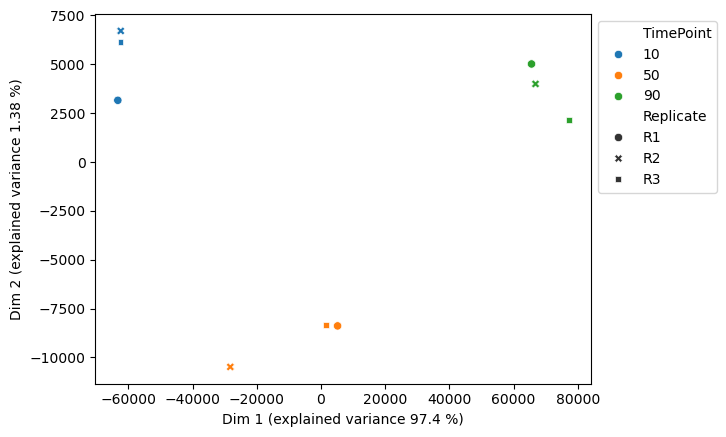

In [21]:
txPCA(tpms[columnOrder])

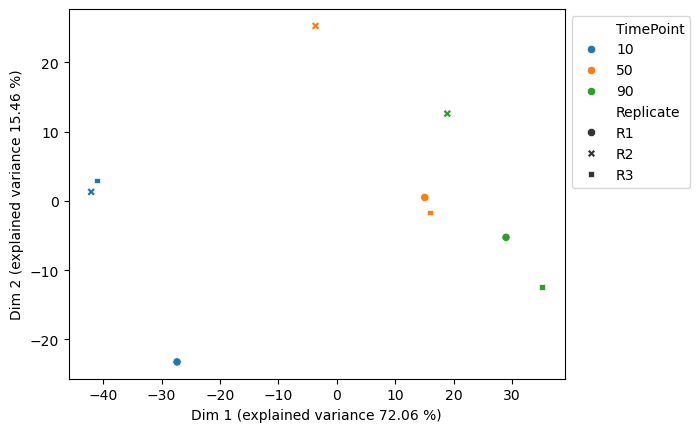

In [22]:
txPCA(logs[columnOrder])

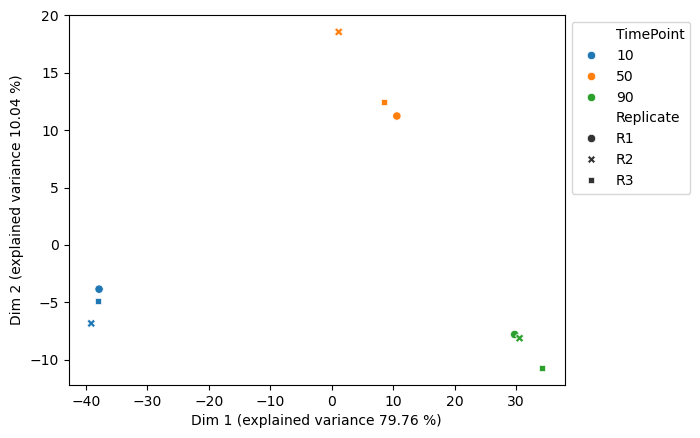

In [23]:
txPCA(logTPMs[columnOrder])

In [24]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

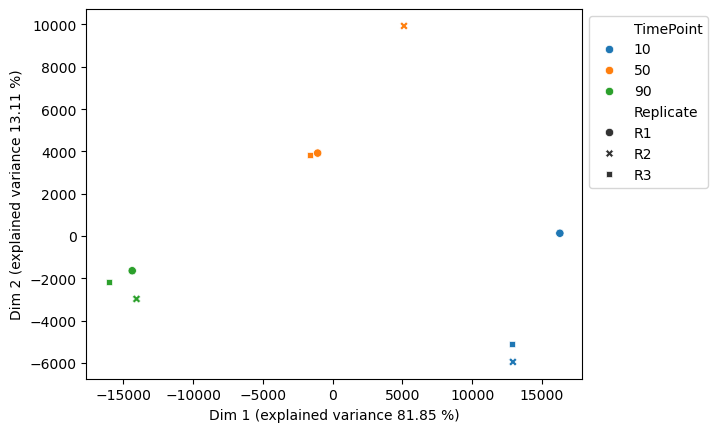

In [25]:
txPCA(tpmHost[columnOrder])

tpmPhage

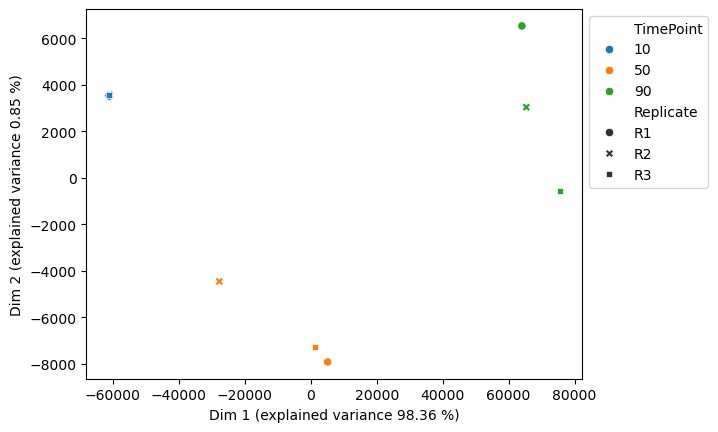

In [26]:
txPCA(tpmPhage[columnOrder])

logTPM Host

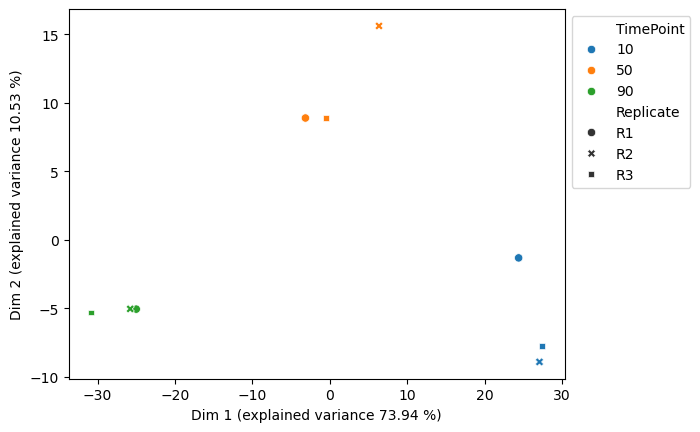

In [27]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

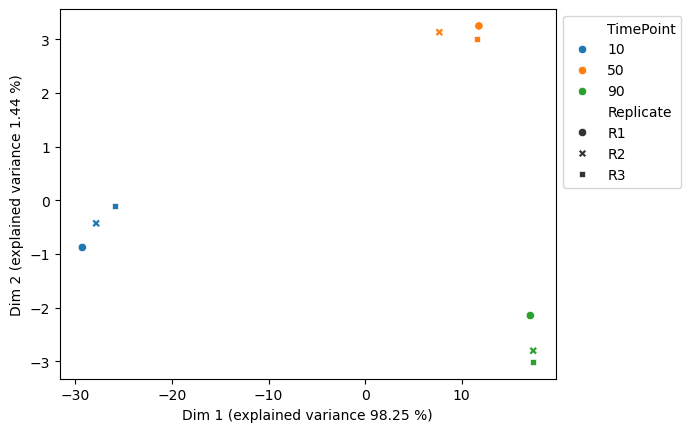

In [28]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Looks fine.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [29]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['10', '50', '90']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,10,50,90,Entity,Symbol
Geneid,,,,,
gene-SPD_RS02505,242.607738,189.043605,103.867309,host,gene-SPD_RS02505
gene-SPD_RS00975,211.146419,170.137299,85.370143,host,uvrA
gene-SPD_RS07040,6.802214,8.779564,7.302560,host,gene-SPD_RS07040
gene-SPD_RS03975,1272.343628,1072.701694,818.358646,host,gene-SPD_RS03975
gene-SPD_RS09415,336.872756,241.749800,156.803507,host,asnA
...,...,...,...,...,...
gene-SPD_RS09045,234.952943,288.427499,184.322749,host,gene-SPD_RS09045
gene-SPD_RS06650,1539.544448,1714.655794,753.792301,host,rpsU
gene-SPD_RS10070,30.644026,57.775431,34.951987,host,gene-SPD_RS10070


In [30]:
TPMsds = TPMsds[['10', '50', '90']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,10,50,90,Entity,Symbol
Geneid,,,,,
gene-SPD_RS02505,17.945630,2.918169,5.782380,host,gene-SPD_RS02505
gene-SPD_RS00975,6.006304,10.843552,3.777722,host,uvrA
gene-SPD_RS07040,2.914672,3.974014,0.406352,host,gene-SPD_RS07040
gene-SPD_RS03975,89.357267,48.598154,37.684953,host,gene-SPD_RS03975
gene-SPD_RS09415,15.260452,18.820812,15.256751,host,asnA
...,...,...,...,...,...
gene-SPD_RS09045,45.135249,105.622410,104.779468,host,gene-SPD_RS09045
gene-SPD_RS06650,90.367969,204.283486,48.468732,host,rpsU
gene-SPD_RS10070,5.367239,5.463588,2.909991,host,gene-SPD_RS10070


In [31]:
propExp = proportionalExp(TPMmeans[['10', '50', '90']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,10,50,90,Entity,Symbol
Geneid,,,,,
gene-SPD_RS02505,1.000000,0.779215,0.428129,host,gene-SPD_RS02505
gene-SPD_RS00975,1.000000,0.805779,0.404317,host,uvrA
gene-SPD_RS07040,0.774778,1.000000,0.831768,host,gene-SPD_RS07040
gene-SPD_RS03975,1.000000,0.843091,0.643190,host,gene-SPD_RS03975
gene-SPD_RS09415,1.000000,0.717629,0.465468,host,asnA
...,...,...,...,...,...
gene-SPD_RS09045,0.814600,1.000000,0.639061,host,gene-SPD_RS09045
gene-SPD_RS06650,0.897874,1.000000,0.439617,host,rpsU
gene-SPD_RS10070,0.530399,1.000000,0.604963,host,gene-SPD_RS10070


## 5. Phage gene classification

In [32]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [34]:
TPMmeans

,10,50,90,Entity,Symbol
Geneid,,,,,
gene-SPD_RS02505,242.607738,189.043605,103.867309,host,gene-SPD_RS02505
gene-SPD_RS00975,211.146419,170.137299,85.370143,host,uvrA
gene-SPD_RS07040,6.802214,8.779564,7.302560,host,gene-SPD_RS07040
gene-SPD_RS03975,1272.343628,1072.701694,818.358646,host,gene-SPD_RS03975
gene-SPD_RS09415,336.872756,241.749800,156.803507,host,asnA
...,...,...,...,...,...
gene-SPD_RS09045,234.952943,288.427499,184.322749,host,gene-SPD_RS09045
gene-SPD_RS06650,1539.544448,1714.655794,753.792301,host,rpsU
gene-SPD_RS10070,30.644026,57.775431,34.951987,host,gene-SPD_RS10070


In [35]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [36]:
pd.set_option('display.max_rows', 20)
TPMmeans[TPMmeans['Entity'] == 'phage'].sort_index()

,10,50,90,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,
gene-SpSL1_01,123.059990,214.600366,366.528521,phage,int,early,late
gene-SpSL1_02,62.138071,216.764349,341.230652,phage,gene-SpSL1_02,middle,late
gene-SpSL1_03,91.483139,323.127525,480.767823,phage,gene-SpSL1_03,middle,late
gene-SpSL1_04,75.962302,256.907497,351.107364,phage,gene-SpSL1_04,early,late
gene-SpSL1_05,7867.369204,7387.849693,2539.282824,phage,gene-SpSL1_05,early,early
...,...,...,...,...,...,...,...
gene-SpSL1_46,28.949360,9890.001001,28607.887959,phage,gene-SpSL1_46,middle,late
gene-SpSL1_47,13.502013,4165.666612,14032.414707,phage,gene-SpSL1_47,middle,late
gene-SpSL1_48,16.249676,6248.202836,25031.035418,phage,hol1,middle,late


In [37]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      27
early     22
middle     1
Name: count, dtype: int64

Add classes to other dfs.

In [38]:
gff3_genes["seq_id"].unique()

array(['NC_008533.2', 'KM882824.1'], dtype=object)

In [39]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NC_008533.2']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'KM882824.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [40]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [41]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,10_R1,10_R2,10_R3,50_R1,50_R2,50_R3,90_R1,90_R2,90_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,
gene-SPD_RS02505,217.916644,260.035688,249.870882,185.126195,192.126583,189.878038,103.154968,111.278500,97.168460,host,gene-SPD_RS02505,None,None,18.962935
gene-SPD_RS00975,210.823300,218.658845,203.957113,162.285092,185.470902,162.655902,83.799583,90.577729,81.733119,host,uvrA,None,None,17.993836
gene-SPD_RS07040,4.494009,4.998764,10.913868,8.564993,13.750454,4.023246,7.377891,6.771511,7.758277,host,gene-SPD_RS07040,None,None,1.160932
gene-SPD_RS03975,1199.842827,1398.231114,1218.956944,1053.635259,1139.419037,1025.050788,815.257005,773.833244,865.985691,host,gene-SPD_RS03975,None,None,36.453309
gene-SPD_RS09415,357.371030,332.470644,320.776596,234.086383,267.656120,223.506896,176.741418,139.692251,153.976851,host,asnA,None,None,23.183297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-SPD_RS09045,266.870269,171.122062,266.866499,269.269285,169.714508,426.298703,305.583312,49.936030,197.448907,host,gene-SPD_RS09045,None,None,41.814519
gene-SPD_RS06650,1504.223570,1663.571618,1450.838155,1524.796789,1998.166267,1621.004327,718.227907,720.827997,822.320998,host,rpsU,None,None,143.718752
gene-SPD_RS10070,38.199078,26.232643,27.500359,61.949899,61.319054,50.057339,34.666925,38.649954,31.539082,host,gene-SPD_RS10070,None,None,3.990549


In [42]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [43]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,10_R1,10_R2,10_R3,50_R1,50_R2,50_R3,90_R1,90_R2,90_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-SPD_RS02505,299,535,518,311,431,291,201,304,180,host,gene-SPD_RS02505
gene-SPD_RS00975,781,1214,1141,736,1123,673,441,668,409,host,uvrA
gene-SPD_RS07040,1,2,5,3,7,1,3,4,3,host,gene-SPD_RS07040
gene-SPD_RS03975,612,1069,939,658,950,584,591,786,597,host,gene-SPD_RS03975
gene-SPD_RS09415,464,647,629,372,568,324,326,361,270,host,asnA
...,...,...,...,...,...,...,...,...,...,...,...
gene-SPD_RS09045,25,24,38,31,26,45,41,9,25,host,gene-SPD_RS09045
gene-SPD_RS06650,348,577,507,432,756,419,236,332,257,host,rpsU
gene-SPD_RS10070,34,35,37,68,90,50,44,69,38,host,gene-SPD_RS10070


In [44]:
# Full TPM table
tpms.to_csv('Furi_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Furi_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Furi_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Furi_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Furi_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Furi_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Furi_phage_gff3.tsv', sep='\t')

In [45]:
tpms.dtypes

SampleNames
10_R1             float64
10_R2             float64
10_R3             float64
50_R1             float64
50_R2             float64
50_R3             float64
90_R1             float64
90_R2             float64
90_R3             float64
Entity             object
Symbol             object
ClassThreshold     object
ClassMax           object
Variance          float64
dtype: object